In [1]:
import os, sys
import numpy as np
import torch
from astropy.table import Table
from sklearn.preprocessing import StandardScaler

sys.path.append("../..")

from astroclip.env import format_with_env
from property_utils.models import few_shot, zero_shot
from property_utils.plotting import plot_scatter

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'
c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\dinov2\layers\swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\dinov2\layers\attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\dinov2\layers\block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [4]:
ASTROCLIP_ROOT =  '../..' # format_with_env("{ASTROCLIP_ROOT}")

PROVABGS_ROOT = f"{ASTROCLIP_ROOT}/datasets/provabgs/"

# Define models in embeddings
image_models = ["astroclip_image", "astrodino", "stein"]
spectrum_models = ["astroclip_spectrum", "specformer"]

# Set up the paths
train_path = os.path.join(PROVABGS_ROOT, "provabgs_paired_train_embeddings.hdf5")
test_path = os.path.join(PROVABGS_ROOT, "provabgs_paired_test_embeddings.hdf5")

In [5]:
# Get embeddings and PROVABGS table
train_provabgs = Table.read(train_path)
test_provabgs = Table.read(test_path)

# Get redshifts
z_train = train_provabgs["Z_HP"]
z_test = test_provabgs["Z_HP"]

# Scale properties
scaler = {"mean": z_train.mean(), "std": z_train.std()}
z_train = (z_train - scaler["mean"]) / scaler["std"]

print(
    "Size of training set:",
    len(train_provabgs),
    "\nSize of test set:",
    len(test_provabgs),
)

Size of training set: 2681 
Size of test set: 2844


# Redshift estimation from image embeddings

In [6]:
# Get data
data = {}
for model in image_models:
    data[model] = {}
    X_train, X_test = (
        train_provabgs[model + "_embeddings"],
        test_provabgs[model + "_embeddings"],
    )
    embedding_scaler = StandardScaler().fit(X_train)
    data[model]["train"] = embedding_scaler.transform(X_train)
    data[model]["test"] = embedding_scaler.transform(X_test)

In [7]:
# Perfrom knn and mlp
preds_knn, preds_mlp = {}, {}
for key in data.keys():
    print(f"Evaluating {key} model...")
    raw_preds_knn = zero_shot(data[key]["train"], z_train, data[key]["test"])
    raw_preds_mlp = few_shot(
        model, data[key]["train"], z_train, data[key]["test"], hidden_dims=[32]
    ).squeeze()
    preds_knn[key] = raw_preds_knn * scaler["std"] + scaler["mean"]
    preds_mlp[key] = raw_preds_mlp * scaler["std"] + scaler["mean"]

Evaluating astroclip_image model...


c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\subp

Evaluating astrodino model...
Evaluating stein model...


c:\OSS\AstroCLIP\downstream_tasks\property_estimation\property_utils\plotting.py:55: RuntimeWarning: Mean of empty slice.
  y_avg = [y[x_binned == i].mean() for i in range(1, len(bins))]
c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mi3se\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c

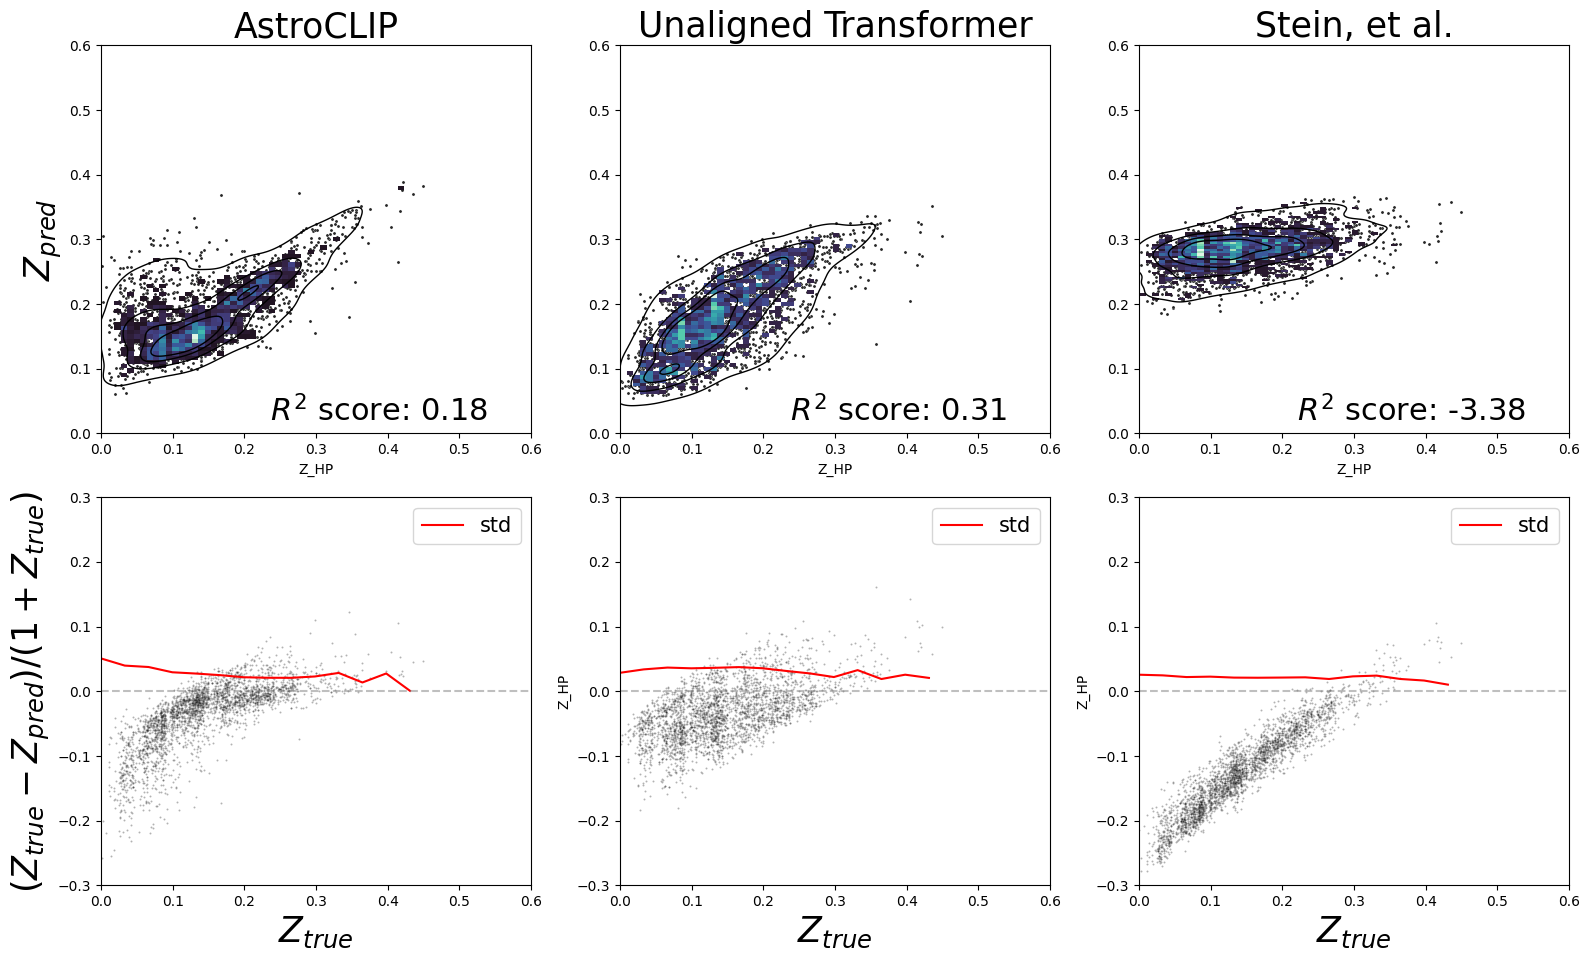

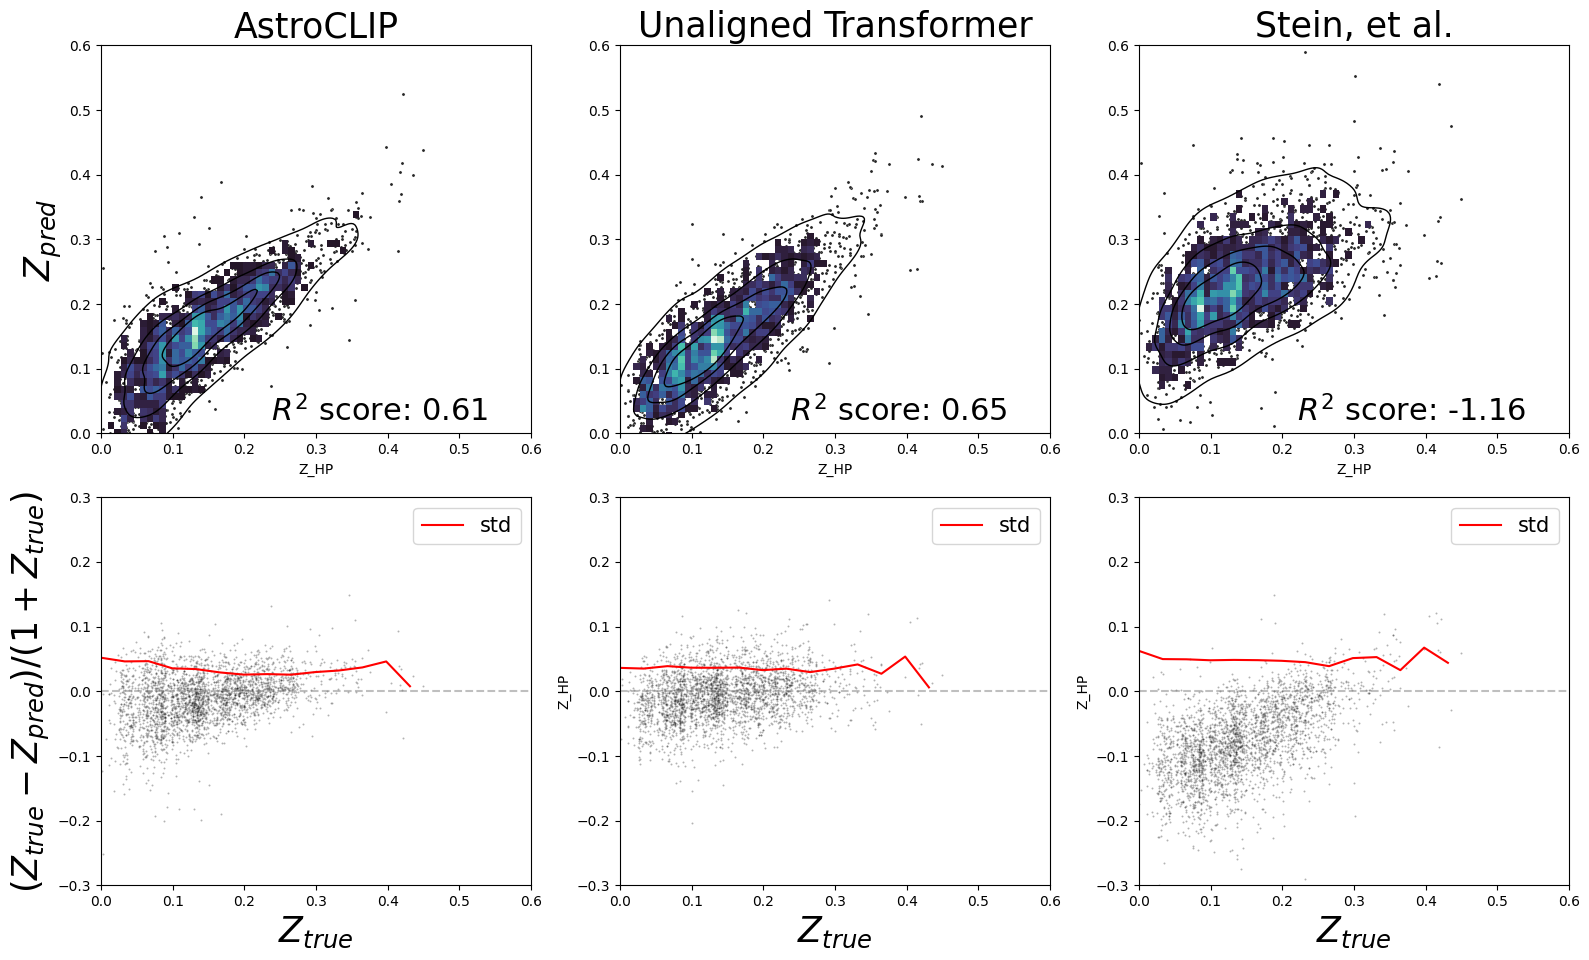

In [8]:
# Clean up names
preds_knn["AstroCLIP"] = preds_knn.pop("astroclip_image")
preds_mlp["AstroCLIP"] = preds_mlp.pop("astroclip_image")

preds_knn["Unaligned Transformer"] = preds_knn.pop("astrodino")
preds_mlp["Unaligned Transformer"] = preds_mlp.pop("astrodino")

preds_knn["Stein, et al."] = preds_knn.pop("stein")
preds_mlp["Stein, et al."] = preds_mlp.pop("stein")

# Plot scatter plots
save_path = "./outputs/redshift/image"
if not os.path.exists(save_path):
    os.makedirs(save_path)
plot_scatter(preds_knn, z_test, save_loc=f"{save_path}/redshift_scatter_knn.png")
plot_scatter(preds_mlp, z_test, save_loc=f"{save_path}/redshift_scatter_mlp.png")

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score


def plot_scatter(
    preds: dict,
    z_test: np.ndarray,
    data_lower_lim: float = 0.0,
    data_upper_lim: float = 0.6,
    save_loc: str = "scatter.png",
) -> None:
    """Functionality to plot redshift scatter plots for different models."""
    fig, ax = plt.subplots(2, len(preds.keys()), figsize=(10, 10))

    for i, name in enumerate(preds.keys()):
        sns.scatterplot(ax=ax[0, i], x=z_test, y=preds[name], s=5, color=".15")
        sns.histplot(
            ax=ax[0, i], x=z_test, y=preds[name], bins=50, pthresh=0.1, cmap="mako"
        )
        sns.kdeplot(
            ax=ax[0, i], x=z_test, y=preds[name], levels=5, color="k", linewidths=1
        )

        ax[0, i].plot(
            data_lower_lim,
            data_upper_lim * 1.1,
            "--",
            linewidth=1.5,
            alpha=0.5,
            color="grey",
        )
        ax[0, i].set_xlim(data_lower_lim, data_upper_lim)
        ax[0, i].set_ylim(data_lower_lim, data_upper_lim)
        ax[0, i].text(
            0.9,
            0.1,
            "$R^2$ score: %0.2f" % r2_score(z_test, preds[name]),
            horizontalalignment="right",
            verticalalignment="top",
            fontsize=22,
            transform=ax[0, i].transAxes,
        )
        ax[0, i].set_title(name, fontsize=25)

    ax[0, 0].set_ylabel("$Z_{pred}$", fontsize=25)

    for i, name in enumerate(preds.keys()):
        x = z_test
        y = (z_test - preds[name]) / (1 + z_test)

        bins = np.linspace(data_lower_lim, data_upper_lim * 1.05, 20)
        x_binned = np.digitize(x, bins)
        y_avg = [y[x_binned == i].mean() for i in range(1, len(bins))]
        y_std = [y[x_binned == i].std() for i in range(1, len(bins))]

        sns.scatterplot(ax=ax[1, i], x=x, y=y, s=2, alpha=0.3, color="black")
        sns.lineplot(ax=ax[1, i], x=bins[:-1], y=y_std, color="r", label="std")

        # horizontal line on y = 0
        ax[1, i].axhline(0, color="grey", linewidth=1.5, alpha=0.5, linestyle="--")

        # sns.scatterplot(ax=ax[1,i], x=bins[:-1], y=y_avg, s=15, color='.15')
        ax[1, i].set_xlim(data_lower_lim, data_upper_lim)
        ax[1, i].set_ylim(-data_upper_lim / 2, data_upper_lim / 2)
        ax[1, i].set_xlabel("$Z_{true}$", fontsize=25)
        ax[1, i].legend(fontsize=15, loc="upper right")

    ax[1, 0].set_ylabel("$(Z_{true}-Z_{pred})/(1+Z_{true})$", fontsize=25)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(save_loc, dpi=300)

In [ ]:
SUPERVISED_ROOT = f"{ASTROCLIP_ROOT}/supervised/"
# Get predictions from  supervised models
preds_supervised = {
    "ResNet18": torch.load(
        os.path.join(SUPERVISED_ROOT, "image/resnet18/redshift-v1/test_pred.pt")
    )["Z_HP"],
    "Photometry MLP": torch.load(
        os.path.join(SUPERVISED_ROOT, "photometry/MLP/redshift/test_pred.pt")
    )["Z_HP"],
}

save_path = "./outputs/redshift/image"
if not os.path.exists(save_path):
    os.makedirs(save_path)
plot_scatter(
    preds_supervised, z_test, save_loc=f"{save_path}/redshift_scatter_supervised.png"
)

# Redshift Estimation from Spectra Embeddings

In [10]:
# Get data
data = {}
for model in spectrum_models:
    data[model] = {}
    X_train, X_test = (
        train_provabgs[model + "_embeddings"],
        test_provabgs[model + "_embeddings"],
    )
    embedding_scaler = StandardScaler().fit(X_train)
    data[model]["train"] = embedding_scaler.transform(X_train)
    data[model]["test"] = embedding_scaler.transform(X_test)

In [11]:
# Perfrom knn and mlp
preds_knn, preds_mlp = {}, {}
for key in data.keys():
    print(f"Evaluating {key} model...")
    raw_preds_knn = zero_shot(data[key]["train"], z_train, data[key]["test"])
    raw_preds_mlp = few_shot(
        model, data[key]["train"], z_train, data[key]["test"]
    ).squeeze()
    preds_knn[key] = raw_preds_knn * scaler["std"] + scaler["mean"]
    preds_mlp[key] = raw_preds_mlp * scaler["std"] + scaler["mean"]

Evaluating astroclip_spectrum model...
Evaluating specformer model...


In [ ]:
# Get predictions from supervised models
spectrum_preds = torch.load(
    os.path.join(SUPERVISED_ROOT, "spectrum/Conv+Att/redshift/test_pred.pt")
)["Z_HP"]

# Add predictions to dictionary
preds_knn["conv+att"] = spectrum_preds
preds_mlp["conv+att"] = spectrum_preds

In [ ]:
# Clean up names
preds_knn["AstroCLIP"] = preds_knn.pop("astroclip_spectrum")
preds_mlp["AstroCLIP"] = preds_mlp.pop("astroclip_spectrum")

preds_knn["Unaligned Transformer"] = preds_knn.pop("specformer")
preds_mlp["Unaligned Transformer"] = preds_mlp.pop("specformer")

preds_knn["Conv+Att"] = preds_knn.pop("conv+att")
preds_mlp["Conv+Att"] = preds_mlp.pop("conv+att")


# Plot scatter plots
save_path = "./outputs/redshift/spectrum"
if not os.path.exists(save_path):
    os.makedirs(save_path)
plot_scatter(preds_knn, z_test, save_loc=f"{save_path}/redshift_scatter_knn.png")
plot_scatter(preds_mlp, z_test, save_loc=f"{save_path}/redshift_scatter_mlp.png")